# Imports

In [17]:
import scipy.io
import numpy as np
import pandas as pd
import os
import warnings
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm


# Ignore all warnings
warnings.filterwarnings('ignore')

# Data Loading

In [18]:
meta_path = "/kaggle/input/stanford-cars-dataset/car_devkit/devkit/cars_meta.mat"
train_annos_path = "/kaggle/input/stanford-cars-dataset/car_devkit/devkit/cars_train_annos.mat"

meta = scipy.io.loadmat(meta_path)
raw_classes = meta['class_names'].flatten()
class_names = [i.item() for i in raw_classes]

train_annos = scipy.io.loadmat(train_annos_path)
raw_annos = train_annos['annotations'][0]

data = []
for sample in raw_annos:
    fname = sample['fname'].item()
    class_id = sample['class'].item()
    class_name = class_names[class_id - 1]
    x1 = sample['bbox_x1'].item()
    y1 = sample['bbox_y1'].item()
    x2 = sample['bbox_x2'].item()
    y2 = sample['bbox_y2'].item()
    data.append([fname, class_id, class_name, x1, y1, x2, y2])

df_train = pd.DataFrame(data, columns=['filename', 'class_id', 'class_name', 'x1', 'y1', 'x2', 'y2'])
print(f"Total Images: {len(df_train)}")
print(f"Total Classes: {len(class_names)}")

Total Images: 8144
Total Classes: 196


In [19]:
class StanfordCarsDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.root_dir, row['filename'])
        image = Image.open(img_path).convert('RGB')
        
        image = image.crop((row['x1'], row['y1'], row['x2'], row['y2']))
        
        label = int(row['class_id']) - 1
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

# Pre-processing

In [20]:
train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [21]:
images_root = '/kaggle/input/stanford-cars-dataset/cars_train/cars_train'

# Split: 70% Train, 15% Val, 15% Test
train_df, test_df1 = train_test_split(
    df_train, 
    test_size=0.3, 
    random_state=42, 
    stratify=df_train['class_id']
)

test_df, val_df = train_test_split(
    test_df1, 
    test_size=0.5, 
    random_state=42, 
    stratify=test_df1['class_id']
)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Testing samples: {len(test_df)}")

# Create datasets
train_ds = StanfordCarsDataset(train_df, images_root, transform=train_transforms)
val_ds = StanfordCarsDataset(val_df, images_root, transform=test_transforms)  # Fix #2
test_ds = StanfordCarsDataset(test_df, images_root, transform=test_transforms)

# Create dataloaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=0)

Training samples: 5700
Validation samples: 1222
Testing samples: 1222


# Model Implementation

In [22]:
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.depthwise = nn.Conv2d(
            in_channels,
            in_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            groups=in_channels,
            bias=False #turned off since the btach norm will add bias
        )
        self.bn1 = nn.BatchNorm2d(in_channels)
        
        self.pointwise = nn.Conv2d(
            in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)
    
    def forward(self, x):
        x = self.depthwise(x)
        x = self.bn1(x)
        x = F.relu6(x) # orignial paper uses relu6
        
        x = self.pointwise(x)
        x = self.bn2(x)
        x = F.relu6(x)
        return x


class MobileNet(nn.Module):
    def __init__(self, num_classes=1000):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.dw_conv2 = DepthwiseSeparableConv(32, 64, 1)
        self.dw_conv3 = DepthwiseSeparableConv(64, 128, 2)
        self.dw_conv4 = DepthwiseSeparableConv(128, 128, 1)
        self.dw_conv5 = DepthwiseSeparableConv(128, 256, 2)
        self.dw_conv6 = DepthwiseSeparableConv(256, 256, 1)
        self.dw_conv7 = DepthwiseSeparableConv(256, 512, 2)
        
        self.dw_conv8 = DepthwiseSeparableConv(512, 512, 1)
        self.dw_conv9 = DepthwiseSeparableConv(512, 512, 1)
        self.dw_conv10 = DepthwiseSeparableConv(512, 512, 1)
        self.dw_conv11 = DepthwiseSeparableConv(512, 512, 1)
        self.dw_conv12 = DepthwiseSeparableConv(512, 512, 1)
        
        self.dw_conv13 = DepthwiseSeparableConv(512, 1024, 2)
        self.dw_conv14 = DepthwiseSeparableConv(1024, 1024, 1)
        
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(1024, num_classes)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        
        x = self.dw_conv2(x)
        x = self.dw_conv3(x)
        x = self.dw_conv4(x)
        x = self.dw_conv5(x)
        x = self.dw_conv6(x)
        x = self.dw_conv7(x)
        x = self.dw_conv8(x)
        x = self.dw_conv9(x)
        x = self.dw_conv10(x)
        x = self.dw_conv11(x)
        x = self.dw_conv12(x)
        x = self.dw_conv13(x)
        x = self.dw_conv14(x)
        
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Model Prep

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = MobileNet(len(class_names));
model = model.to(device)
assert model.fc.out_features == len(class_names), "Model output doesn't match number of classes!"
print(f"Model ready: MobileNet V1 for {len(class_names)} classes")

Using device: cuda
Model ready: MobileNet V1 for 196 classes


In [24]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, path='best_checkpoint.pth'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.path = path
    
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(model)
            self.counter = 0
    
    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.path)
        print(f'Validation loss improved. Saving model...')

In [25]:
def mixup_data(x, y, alpha=0.2):
    """Mixup augmentation"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)
    
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# Training

In [ ]:
print("\n" + "="*70)
print("Training MobileNet")
print("="*70)

num_epochs = 75

for param in model.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # Add label smoothing

optimizer = optim.SGD(
    model.parameters(), 
    lr=0.1,
    momentum=0.9,
    weight_decay=4e-5,
    nesterov=True
)

scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer, 
    T_max=num_epochs, 
    eta_min=1e-6
)

early_stopper = EarlyStopping(
    patience=25,
    min_delta=0.001, 
    path='mobilenet_best_SGD.pth'
)

for epoch in range(num_epochs):
    print(f"\n=== Epoch {epoch+1}/{num_epochs} ===")
    
    model.train()
    train_loss = 0
    train_correct = 0
    
    loop = tqdm(train_loader, desc="Training")
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()
        
        loop.set_postfix(loss=loss.item())
    
    avg_train_loss = train_loss / len(train_loader.dataset)
    train_acc = train_correct / len(train_loader.dataset)
    
    model.eval()
    val_loss = 0
    val_correct = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
    
    avg_val_loss = val_loss / len(val_loader.dataset)
    val_acc = val_correct / len(val_loader.dataset)
    
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {avg_val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    print(f"Learning Rate: {current_lr:.6f}")
    
    scheduler.step()
    
    early_stopper(avg_val_loss, model)
    
    if early_stopper.early_stop:
        print("Early stopping triggered!")
        break

model.load_state_dict(torch.load('mobilenet_best_SGD.pth'))
print("\nTraining complete. Loaded best weights.")


Training MobileNet

=== Epoch 1/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 5.3632 | Train Acc: 0.0037
Val Loss:   5.4335 | Val Acc:   0.0049
Learning Rate: 0.100000
Validation loss improved. Saving model...

=== Epoch 2/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 5.3955 | Train Acc: 0.0081
Val Loss:   5.4588 | Val Acc:   0.0098
Learning Rate: 0.099956
EarlyStopping counter: 1 out of 25

=== Epoch 3/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 5.2933 | Train Acc: 0.0081
Val Loss:   5.2015 | Val Acc:   0.0123
Learning Rate: 0.099825
Validation loss improved. Saving model...

=== Epoch 4/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 5.1889 | Train Acc: 0.0088
Val Loss:   5.1297 | Val Acc:   0.0196
Learning Rate: 0.099606
Validation loss improved. Saving model...

=== Epoch 5/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 5.1462 | Train Acc: 0.0132
Val Loss:   5.0970 | Val Acc:   0.0164
Learning Rate: 0.099300
Validation loss improved. Saving model...

=== Epoch 6/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 5.0878 | Train Acc: 0.0167
Val Loss:   5.1198 | Val Acc:   0.0196
Learning Rate: 0.098429
EarlyStopping counter: 2 out of 25

=== Epoch 8/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 5.0581 | Train Acc: 0.0216
Val Loss:   5.0785 | Val Acc:   0.0213
Learning Rate: 0.097866
Validation loss improved. Saving model...

=== Epoch 9/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 5.0411 | Train Acc: 0.0218
Val Loss:   5.0534 | Val Acc:   0.0205
Learning Rate: 0.097219
Validation loss improved. Saving model...

=== Epoch 10/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 5.0110 | Train Acc: 0.0225
Val Loss:   5.0244 | Val Acc:   0.0245
Learning Rate: 0.096489
Validation loss improved. Saving model...

=== Epoch 11/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 4.9500 | Train Acc: 0.0300
Val Loss:   4.8969 | Val Acc:   0.0393
Learning Rate: 0.095677
Validation loss improved. Saving model...

=== Epoch 12/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 4.8770 | Train Acc: 0.0321
Val Loss:   4.7502 | Val Acc:   0.0475
Learning Rate: 0.094786
Validation loss improved. Saving model...

=== Epoch 13/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 4.7962 | Train Acc: 0.0388
Val Loss:   4.7355 | Val Acc:   0.0475
Learning Rate: 0.093815
Validation loss improved. Saving model...

=== Epoch 14/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 4.6695 | Train Acc: 0.0542
Val Loss:   4.6186 | Val Acc:   0.0679
Learning Rate: 0.092768
Validation loss improved. Saving model...

=== Epoch 15/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 4.5663 | Train Acc: 0.0611
Val Loss:   4.5092 | Val Acc:   0.0589
Learning Rate: 0.091646
Validation loss improved. Saving model...

=== Epoch 16/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 4.4460 | Train Acc: 0.0768
Val Loss:   4.4108 | Val Acc:   0.0933
Learning Rate: 0.090451
Validation loss improved. Saving model...

=== Epoch 17/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 4.3583 | Train Acc: 0.0904
Val Loss:   4.2211 | Val Acc:   0.1007
Learning Rate: 0.089185
Validation loss improved. Saving model...

=== Epoch 18/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 4.2211 | Train Acc: 0.1068
Val Loss:   4.0687 | Val Acc:   0.1424
Learning Rate: 0.087850
Validation loss improved. Saving model...

=== Epoch 19/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 4.1126 | Train Acc: 0.1270
Val Loss:   4.0141 | Val Acc:   0.1432
Learning Rate: 0.086449
Validation loss improved. Saving model...

=== Epoch 20/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 3.9882 | Train Acc: 0.1446
Val Loss:   3.8059 | Val Acc:   0.1809
Learning Rate: 0.084983
Validation loss improved. Saving model...

=== Epoch 21/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 3.8951 | Train Acc: 0.1602
Val Loss:   3.8268 | Val Acc:   0.1890
Learning Rate: 0.083457
EarlyStopping counter: 1 out of 25

=== Epoch 22/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 3.7762 | Train Acc: 0.2007
Val Loss:   3.7199 | Val Acc:   0.2087
Learning Rate: 0.081871
Validation loss improved. Saving model...

=== Epoch 23/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 3.6641 | Train Acc: 0.2237
Val Loss:   3.5932 | Val Acc:   0.2398
Learning Rate: 0.080230
Validation loss improved. Saving model...

=== Epoch 24/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 3.5504 | Train Acc: 0.2440
Val Loss:   3.4936 | Val Acc:   0.2561
Learning Rate: 0.078536
Validation loss improved. Saving model...

=== Epoch 25/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 3.4503 | Train Acc: 0.2740
Val Loss:   3.4172 | Val Acc:   0.2774
Learning Rate: 0.076792
Validation loss improved. Saving model...

=== Epoch 26/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 3.3496 | Train Acc: 0.2984
Val Loss:   3.2270 | Val Acc:   0.3331
Learning Rate: 0.075000
Validation loss improved. Saving model...

=== Epoch 27/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 3.2277 | Train Acc: 0.3261
Val Loss:   3.2553 | Val Acc:   0.3527
Learning Rate: 0.073165
EarlyStopping counter: 1 out of 25

=== Epoch 28/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 3.1697 | Train Acc: 0.3423
Val Loss:   3.1536 | Val Acc:   0.3494
Learning Rate: 0.071289
Validation loss improved. Saving model...

=== Epoch 29/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 3.0618 | Train Acc: 0.3726
Val Loss:   3.1192 | Val Acc:   0.3633
Learning Rate: 0.069376
Validation loss improved. Saving model...

=== Epoch 30/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 2.9642 | Train Acc: 0.3998
Val Loss:   2.9753 | Val Acc:   0.4018
Learning Rate: 0.067429
Validation loss improved. Saving model...

=== Epoch 31/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 2.8918 | Train Acc: 0.4363
Val Loss:   2.9128 | Val Acc:   0.4190
Learning Rate: 0.065451
Validation loss improved. Saving model...

=== Epoch 32/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 2.8042 | Train Acc: 0.4509
Val Loss:   2.9018 | Val Acc:   0.4427
Learning Rate: 0.063446
Validation loss improved. Saving model...

=== Epoch 33/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 2.7144 | Train Acc: 0.4754
Val Loss:   2.7720 | Val Acc:   0.4795
Learning Rate: 0.061418
Validation loss improved. Saving model...

=== Epoch 34/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 2.6352 | Train Acc: 0.5051
Val Loss:   2.6821 | Val Acc:   0.4885
Learning Rate: 0.059369
Validation loss improved. Saving model...

=== Epoch 35/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 2.5788 | Train Acc: 0.5177
Val Loss:   2.6570 | Val Acc:   0.5098
Learning Rate: 0.057305
Validation loss improved. Saving model...

=== Epoch 36/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 2.5135 | Train Acc: 0.5360
Val Loss:   2.6253 | Val Acc:   0.5082
Learning Rate: 0.055227
Validation loss improved. Saving model...

=== Epoch 37/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 2.4438 | Train Acc: 0.5589
Val Loss:   2.6271 | Val Acc:   0.5016
Learning Rate: 0.053140
EarlyStopping counter: 1 out of 25

=== Epoch 38/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 2.3742 | Train Acc: 0.5830
Val Loss:   2.5886 | Val Acc:   0.5229
Learning Rate: 0.051048
Validation loss improved. Saving model...

=== Epoch 39/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 2.3282 | Train Acc: 0.6011
Val Loss:   2.4691 | Val Acc:   0.5679
Learning Rate: 0.048953
Validation loss improved. Saving model...

=== Epoch 40/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 2.2514 | Train Acc: 0.6270
Val Loss:   2.4836 | Val Acc:   0.5687
Learning Rate: 0.046861
EarlyStopping counter: 1 out of 25

=== Epoch 41/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 2.2115 | Train Acc: 0.6465
Val Loss:   2.4007 | Val Acc:   0.6015
Learning Rate: 0.044774
Validation loss improved. Saving model...

=== Epoch 42/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 2.1486 | Train Acc: 0.6616
Val Loss:   2.4018 | Val Acc:   0.5908
Learning Rate: 0.042696
EarlyStopping counter: 1 out of 25

=== Epoch 43/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 2.1169 | Train Acc: 0.6696
Val Loss:   2.3213 | Val Acc:   0.6113
Learning Rate: 0.040632
Validation loss improved. Saving model...

=== Epoch 44/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 2.0560 | Train Acc: 0.6851
Val Loss:   2.3217 | Val Acc:   0.6056
Learning Rate: 0.038583
EarlyStopping counter: 1 out of 25

=== Epoch 45/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 2.0333 | Train Acc: 0.6933
Val Loss:   2.2888 | Val Acc:   0.6227
Learning Rate: 0.036555
Validation loss improved. Saving model...

=== Epoch 46/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 1.9801 | Train Acc: 0.7188
Val Loss:   2.2743 | Val Acc:   0.6236
Learning Rate: 0.034550
Validation loss improved. Saving model...

=== Epoch 47/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 1.9365 | Train Acc: 0.7302
Val Loss:   2.2398 | Val Acc:   0.6416
Learning Rate: 0.032572
Validation loss improved. Saving model...

=== Epoch 48/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 1.9099 | Train Acc: 0.7425
Val Loss:   2.1954 | Val Acc:   0.6473
Learning Rate: 0.030625
Validation loss improved. Saving model...

=== Epoch 49/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 1.8600 | Train Acc: 0.7570
Val Loss:   2.2245 | Val Acc:   0.6334
Learning Rate: 0.028712
EarlyStopping counter: 1 out of 25

=== Epoch 50/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 1.8354 | Train Acc: 0.7665
Val Loss:   2.1536 | Val Acc:   0.6661
Learning Rate: 0.026836
Validation loss improved. Saving model...

=== Epoch 51/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 1.8043 | Train Acc: 0.7761
Val Loss:   2.1619 | Val Acc:   0.6538
Learning Rate: 0.025001
EarlyStopping counter: 1 out of 25

=== Epoch 52/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 1.7769 | Train Acc: 0.7916
Val Loss:   2.1461 | Val Acc:   0.6571
Learning Rate: 0.023209
Validation loss improved. Saving model...

=== Epoch 53/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 1.7501 | Train Acc: 0.7940
Val Loss:   2.0799 | Val Acc:   0.6817
Learning Rate: 0.021465
Validation loss improved. Saving model...

=== Epoch 54/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 1.7320 | Train Acc: 0.7963
Val Loss:   2.1079 | Val Acc:   0.6645
Learning Rate: 0.019771
EarlyStopping counter: 1 out of 25

=== Epoch 55/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 1.6991 | Train Acc: 0.8121
Val Loss:   2.1150 | Val Acc:   0.6759
Learning Rate: 0.018130
EarlyStopping counter: 2 out of 25

=== Epoch 56/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 1.6621 | Train Acc: 0.8279
Val Loss:   2.0686 | Val Acc:   0.6923
Learning Rate: 0.016544
Validation loss improved. Saving model...

=== Epoch 57/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 1.6555 | Train Acc: 0.8226
Val Loss:   2.0694 | Val Acc:   0.6833
Learning Rate: 0.015018
EarlyStopping counter: 1 out of 25

=== Epoch 58/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 1.6402 | Train Acc: 0.8321
Val Loss:   2.0584 | Val Acc:   0.6964
Learning Rate: 0.013552
Validation loss improved. Saving model...

=== Epoch 59/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 1.6147 | Train Acc: 0.8384
Val Loss:   2.0462 | Val Acc:   0.6939
Learning Rate: 0.012151
Validation loss improved. Saving model...

=== Epoch 60/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 1.5820 | Train Acc: 0.8537
Val Loss:   2.0409 | Val Acc:   0.6931
Learning Rate: 0.010816
Validation loss improved. Saving model...

=== Epoch 61/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 1.5883 | Train Acc: 0.8504
Val Loss:   2.0276 | Val Acc:   0.7013
Learning Rate: 0.009550
Validation loss improved. Saving model...

=== Epoch 62/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 1.5634 | Train Acc: 0.8561
Val Loss:   2.0078 | Val Acc:   0.7021
Learning Rate: 0.008355
Validation loss improved. Saving model...

=== Epoch 63/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 1.5787 | Train Acc: 0.8533
Val Loss:   2.0034 | Val Acc:   0.7038
Learning Rate: 0.007233
Validation loss improved. Saving model...

=== Epoch 64/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 1.5315 | Train Acc: 0.8742
Val Loss:   1.9962 | Val Acc:   0.7054
Learning Rate: 0.006186
Validation loss improved. Saving model...

=== Epoch 65/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 1.5440 | Train Acc: 0.8661
Val Loss:   1.9955 | Val Acc:   0.7111
Learning Rate: 0.005215
EarlyStopping counter: 1 out of 25

=== Epoch 66/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 1.5248 | Train Acc: 0.8746
Val Loss:   1.9776 | Val Acc:   0.7136
Learning Rate: 0.004324
Validation loss improved. Saving model...

=== Epoch 67/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 1.5306 | Train Acc: 0.8696
Val Loss:   1.9765 | Val Acc:   0.7119
Learning Rate: 0.003512
Validation loss improved. Saving model...

=== Epoch 68/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 1.5194 | Train Acc: 0.8730
Val Loss:   2.0012 | Val Acc:   0.7046
Learning Rate: 0.002782
EarlyStopping counter: 1 out of 25

=== Epoch 69/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 1.5198 | Train Acc: 0.8728
Val Loss:   1.9832 | Val Acc:   0.7079
Learning Rate: 0.002135
EarlyStopping counter: 2 out of 25

=== Epoch 70/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 1.4986 | Train Acc: 0.8861
Val Loss:   1.9649 | Val Acc:   0.7152
Learning Rate: 0.001572
Validation loss improved. Saving model...

=== Epoch 71/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 1.5093 | Train Acc: 0.8811
Val Loss:   1.9568 | Val Acc:   0.7185
Learning Rate: 0.001094
Validation loss improved. Saving model...

=== Epoch 72/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 1.5086 | Train Acc: 0.8825
Val Loss:   1.9648 | Val Acc:   0.7177
Learning Rate: 0.000701
EarlyStopping counter: 1 out of 25

=== Epoch 73/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 1.4958 | Train Acc: 0.8861
Val Loss:   1.9568 | Val Acc:   0.7136
Learning Rate: 0.000395
EarlyStopping counter: 2 out of 25

=== Epoch 74/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 1.4965 | Train Acc: 0.8839
Val Loss:   1.9662 | Val Acc:   0.7103
Learning Rate: 0.000176
EarlyStopping counter: 3 out of 25

=== Epoch 75/75 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 1.5043 | Train Acc: 0.8847
Val Loss:   1.9699 | Val Acc:   0.7144
Learning Rate: 0.000045
EarlyStopping counter: 4 out of 25

Training complete. Loaded best weights.


In [26]:
def evaluate_model(model, loader, device):
    model.eval()
    correct_1 = 0
    correct_5 = 0
    total = 0
    total_loss = 0  # Add this
    all_preds = []
    all_labels = []
    
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            # --- Log Loss Calculation ---
            loss = criterion(outputs, labels)
            total_loss += loss.item() * labels.size(0)
            
            # --- Top-1 Accuracy ---
            _, pred_1 = torch.max(outputs, 1)
            correct_1 += (pred_1 == labels).sum().item()
            
            # --- Top-5 Accuracy ---
            _, pred_5 = outputs.topk(5, 1, largest=True, sorted=True)
            correct_5 += (pred_5 == labels.view(-1, 1)).sum().item()
            
            total += labels.size(0)
            all_preds.extend(pred_1.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    top1_acc = correct_1 / total
    top5_acc = correct_5 / total
    log_loss = total_loss / total
    
    return top1_acc, top5_acc, log_loss, all_labels, all_preds

device = torch.device("cuda")
model.load_state_dict(torch.load('/kaggle/input/mobilestan/pytorch/default/1/mobilenet_best.pth'))
acc_1, acc_5, logloss, y_true, y_pred = evaluate_model(model, test_loader, device)

print("-" * 30)
print(f"Top-1 Accuracy: {acc_1*100:.2f}%")
print(f"Top-5 Accuracy: {acc_5*100:.2f}%")
print("-" * 30)
print(f"Log Loss: {logloss:.4f}")  # Fixed
print("-" * 30)

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

------------------------------
Top-1 Accuracy: 62.11%
Top-5 Accuracy: 85.43%
------------------------------
Log Loss: 1.5188
------------------------------


In [27]:
from sklearn.metrics import classification_report

print("\n" + "="*70)
print("DETAILED CLASSIFICATION REPORT")
print("="*70)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


DETAILED CLASSIFICATION REPORT
                                                        precision    recall  f1-score   support

                            AM General Hummer SUV 2000     0.6667    0.5714    0.6154         7
                                   Acura RL Sedan 2012     0.4000    0.4000    0.4000         5
                                   Acura TL Sedan 2012     0.5556    0.8333    0.6667         6
                                  Acura TL Type-S 2008     0.5000    0.8333    0.6250         6
                                  Acura TSX Sedan 2012     0.8000    0.6667    0.7273         6
                             Acura Integra Type R 2001     0.5000    0.3333    0.4000         6
                              Acura ZDX Hatchback 2012     0.7500    0.5000    0.6000         6
              Aston Martin V8 Vantage Convertible 2012     0.4000    0.2857    0.3333         7
                    Aston Martin V8 Vantage Coupe 2012     0.2500    0.3333    0.2857         6
       


SAMPLE MISCLASSIFICATIONS


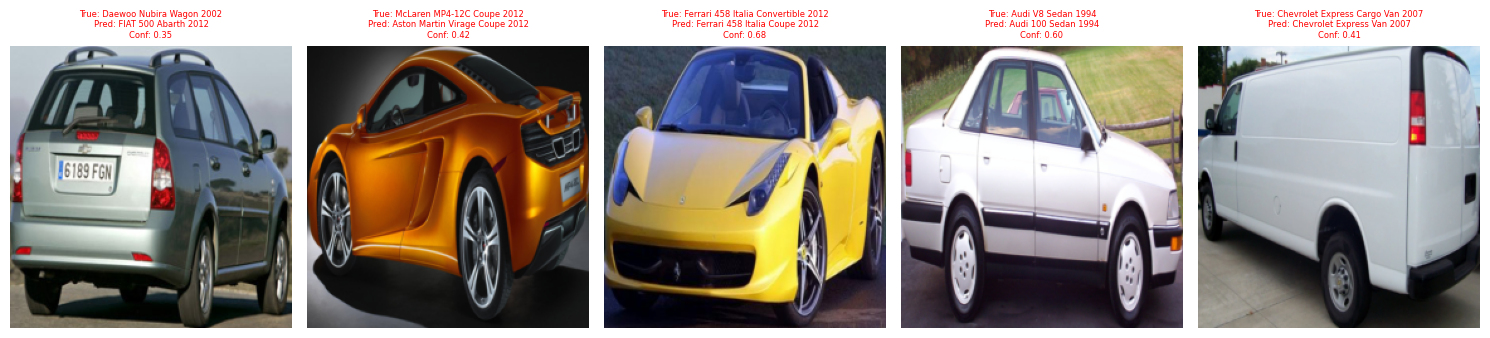

In [28]:
import matplotlib.pyplot as plt

def visualize_failures(model, loader, device, num_images=5):
    model.eval()
    images_shown = 0
    
    plt.figure(figsize=(15, 10))
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs, preds = torch.max(torch.softmax(outputs, dim=1), 1)
            
            for i in range(len(images)):
                if preds[i] != labels[i]:
                    if images_shown >= num_images:
                        plt.tight_layout()
                        plt.show()
                        return
                    
                    # Undo normalization
                    img = images[i].cpu().permute(1, 2, 0).numpy()
                    img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
                    img = np.clip(img, 0, 1)
                    
                    true_name = class_names[labels[i].item()]
                    pred_name = class_names[preds[i].item()]
                    confidence = probs[i].item()
                    
                    ax = plt.subplot(1, num_images, images_shown + 1)
                    plt.imshow(img)
                    plt.title(f"True: {true_name}\nPred: {pred_name}\nConf: {confidence:.2f}", 
                             fontsize=6, color='red')
                    plt.axis('off')
                    
                    images_shown += 1
    
    plt.tight_layout()
    plt.show()

print("\n" + "="*70)
print("SAMPLE MISCLASSIFICATIONS")
print("="*70)
visualize_failures(model, test_loader, device, num_images=5)

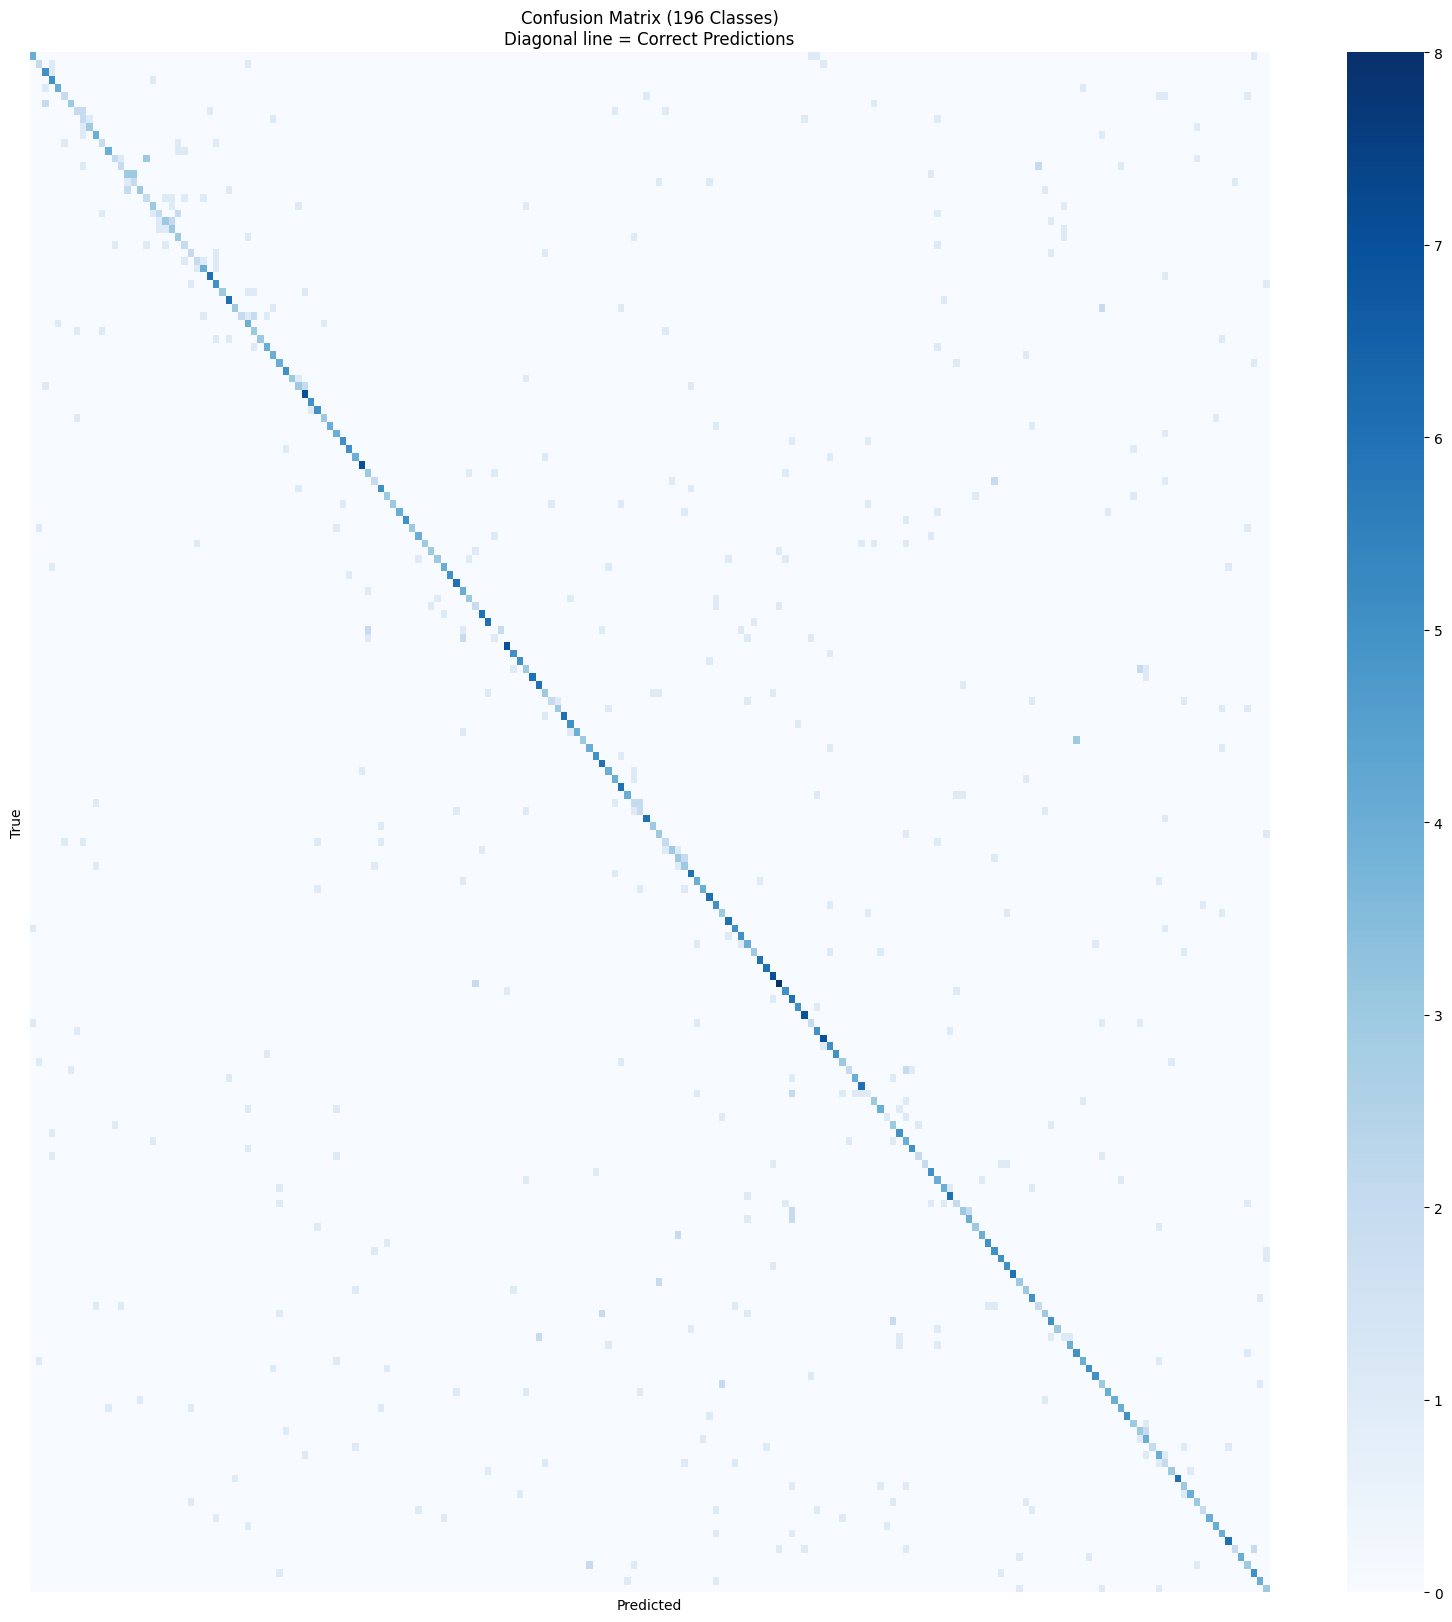

In [29]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', 
            xticklabels=False, yticklabels=False) # Labels hidden for clarity

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (196 Classes)\nDiagonal line = Correct Predictions')
plt.show()

Getting Probabilities:   0%|          | 0/39 [00:00<?, ?it/s]

--------------------------------------------------
Macro-Average AUC: 0.9892
Micro-Average AUC: 0.9890
Average per-class AUC: 0.9889
--------------------------------------------------


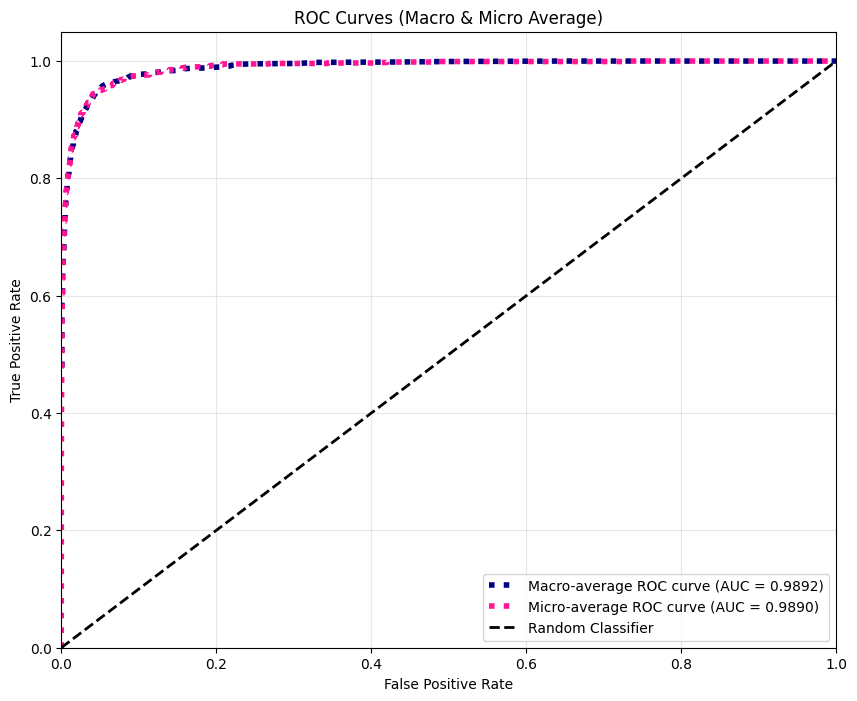

In [30]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score

def get_all_probs(model, loader, device):
    model.eval()
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Getting Probabilities"):
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)  # Convert logits to probabilities
            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.numpy())
    
    return np.concatenate(all_probs), np.concatenate(all_labels)

y_probs, y_test_np = get_all_probs(model, test_loader, device)

n_classes = len(class_names)
y_test_bin = label_binarize(y_test_np, classes=range(n_classes))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Alternative: Using sklearn's built-in functions
macro_auc = roc_auc_score(y_test_bin, y_probs, average='macro')
micro_auc = roc_auc_score(y_test_bin, y_probs, average='micro')

# Print AUC values
print("-" * 50)
print(f"Macro-Average AUC: {roc_auc['macro']:.4f}")
print(f"Micro-Average AUC: {roc_auc['micro']:.4f}")
print(f"Average per-class AUC: {np.mean(list(roc_auc[i] for i in range(n_classes))):.4f}")
print("-" * 50)

# Plotting
plt.figure(figsize=(10, 8))

plt.plot(fpr["macro"], tpr["macro"],
         label=f'Macro-average ROC curve (AUC = {roc_auc["macro"]:.4f})',
         color='navy', linestyle=':', linewidth=4)

plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC curve (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Macro & Micro Average)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


Highest AUC Scores)
1.0000 | Dodge Dakota Club Cab 2007
1.0000 | Ford Freestar Minivan 2007
1.0000 | Ford Fiesta Sedan 2012
1.0000 | Geo Metro Convertible 1993
1.0000 | Honda Odyssey Minivan 2012
1.0000 | Hyundai Tucson SUV 2012
1.0000 | Lincoln Town Car Sedan 2011
1.0000 | Volkswagen Golf Hatchback 2012
0.9999 | Ford E-Series Wagon Van 2012
0.9999 | Ram C/V Cargo Van Minivan 2012

Lowest AUC Scores
0.9587 | Hyundai Veracruz SUV 2012
0.9581 | Nissan Juke Hatchback 2012
0.9548 | Buick Verano Sedan 2012
0.9536 | Audi 100 Wagon 1994
0.9504 | BMW 1 Series Convertible 2012
0.9445 | Toyota Sequoia SUV 2012
0.9378 | BMW 3 Series Sedan 2012
0.9102 | Aston Martin V8 Vantage Coupe 2012
0.9053 | Jeep Liberty SUV 2012
0.8742 | Suzuki SX4 Hatchback 2012


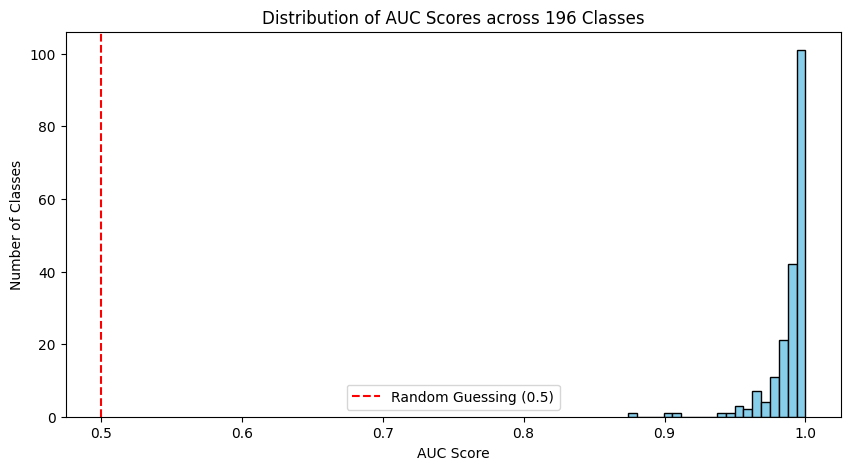

In [31]:
auc_scores = []
for i in range(len(class_names)):
    auc_scores.append((class_names[i], roc_auc[i]))

auc_scores.sort(key=lambda x: x[1], reverse=True)

print("\n" + "="*40)
print("Highest AUC Scores)")
print("="*40)
for name, score in auc_scores[:10]:
    print(f"{score:.4f} | {name}")

print("\n" + "="*40)
print("Lowest AUC Scores")
print("="*40)
for name, score in auc_scores[-10:]:
    print(f"{score:.4f} | {name}")

plt.figure(figsize=(10, 5))
plt.hist([score for name, score in auc_scores], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of AUC Scores across 196 Classes')
plt.xlabel('AUC Score')
plt.ylabel('Number of Classes')
plt.axvline(x=0.5, color='red', linestyle='--', label='Random Guessing (0.5)')
plt.legend()
plt.show()


Highest AUC Scores (Best Performing Classes)
1.0000 | Dodge Dakota Club Cab 2007
1.0000 | Ford Freestar Minivan 2007
1.0000 | Ford Fiesta Sedan 2012
1.0000 | Geo Metro Convertible 1993
1.0000 | Honda Odyssey Minivan 2012
1.0000 | Hyundai Tucson SUV 2012
1.0000 | Lincoln Town Car Sedan 2011
1.0000 | Volkswagen Golf Hatchback 2012
0.9999 | Ford E-Series Wagon Van 2012
0.9999 | Ram C/V Cargo Van Minivan 2012

Lowest AUC Scores (Worst Performing Classes)
0.9587 | Hyundai Veracruz SUV 2012
0.9581 | Nissan Juke Hatchback 2012
0.9548 | Buick Verano Sedan 2012
0.9536 | Audi 100 Wagon 1994
0.9504 | BMW 1 Series Convertible 2012
0.9445 | Toyota Sequoia SUV 2012
0.9378 | BMW 3 Series Sedan 2012
0.9102 | Aston Martin V8 Vantage Coupe 2012
0.9053 | Jeep Liberty SUV 2012
0.8742 | Suzuki SX4 Hatchback 2012

AUC Statistics
Mean AUC:   0.9889
Median AUC: 0.9944
Std Dev:    0.0162
Min AUC:    0.8742
Max AUC:    1.0000

Performance Distribution:
  Excellent (≥0.90): 195 classes
  Good (0.80-0.89):  1 cl

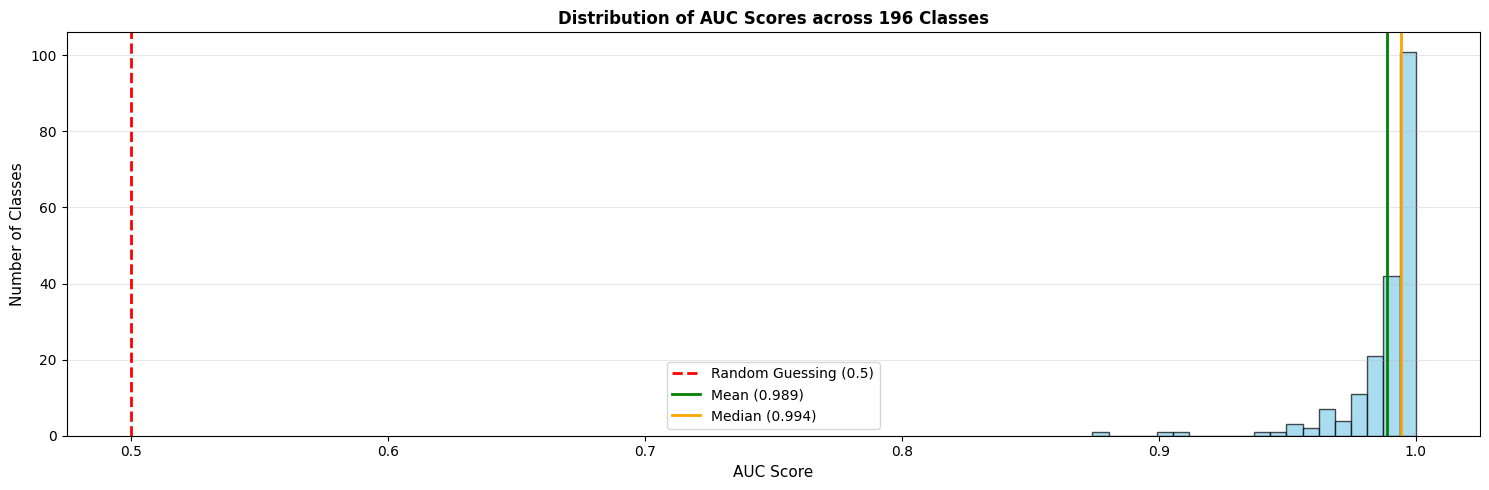

In [32]:
import matplotlib.pyplot as plt
import numpy as np

auc_scores = []
for i in range(len(class_names)):
    auc_scores.append((class_names[i], roc_auc[i]))

auc_scores.sort(key=lambda x: x[1], reverse=True)

print("\n" + "="*50)
print("Highest AUC Scores (Best Performing Classes)")
print("="*50)
for name, score in auc_scores[:10]:
    print(f"{score:.4f} | {name}")

print("\n" + "="*50)
print("Lowest AUC Scores (Worst Performing Classes)")
print("="*50)
for name, score in auc_scores[-10:]:
    print(f"{score:.4f} | {name}")

# Calculate summary statistics
auc_values = [score for name, score in auc_scores]
mean_auc = np.mean(auc_values)
median_auc = np.median(auc_values)
std_auc = np.std(auc_values)

print("\n" + "="*50)
print("AUC Statistics")
print("="*50)
print(f"Mean AUC:   {mean_auc:.4f}")
print(f"Median AUC: {median_auc:.4f}")
print(f"Std Dev:    {std_auc:.4f}")
print(f"Min AUC:    {min(auc_values):.4f}")
print(f"Max AUC:    {max(auc_values):.4f}")

# Count classes by performance level
excellent = sum(1 for score in auc_values if score >= 0.9)
good = sum(1 for score in auc_values if 0.8 <= score < 0.9)
fair = sum(1 for score in auc_values if 0.7 <= score < 0.8)
poor = sum(1 for score in auc_values if score < 0.7)

print(f"\nPerformance Distribution:")
print(f"  Excellent (≥0.90): {excellent} classes")
print(f"  Good (0.80-0.89):  {good} classes")
print(f"  Fair (0.70-0.79):  {fair} classes")
print(f"  Poor (<0.70):      {poor} classes")

# Visualization
plt.figure(figsize=(15, 5))

# Histogram
plt.hist(auc_values, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Random Guessing (0.5)')
plt.axvline(x=mean_auc, color='green', linestyle='-', linewidth=2, label=f'Mean ({mean_auc:.3f})')
plt.axvline(x=median_auc, color='orange', linestyle='-', linewidth=2, label=f'Median ({median_auc:.3f})')
plt.title(f'Distribution of AUC Scores across {len(class_names)} Classes', fontsize=12, fontweight='bold')
plt.xlabel('AUC Score', fontsize=11)
plt.ylabel('Number of Classes', fontsize=11)
plt.legend()
plt.grid(axis='y', alpha=0.3)


plt.tight_layout()
plt.show()